In [1]:
from htmd.ui import *
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
import pandas as pd

2023-07-04 16:58:13,083 - numexpr.utils - INFO - NumExpr defaulting to 8 threads.
/Users/toni/Apps/anaconda-m1/lib/python3.9/site-packages/conda/models/match_spec.py:773: UserWarning: 'name' specified both inside (htmd) and outside (*) of brackets. the value outside of brackets ({components['name']}) will be used.
  warnings.warn(


You are on the latest HTMD version (unpackaged : /Users/toni/Apps/anaconda-m1/envs/htmd/lib/python3.10/site-packages/htmd).



In [2]:
nc_metric= MetricData()
nc_metric.load('metrics/nc.htmd')

rmsd_metric= MetricData()
rmsd_metric.load("metrics/rmsd.htmd")

In [3]:
nc_metric.trajectories[0].sim.trajectory

['/Users/toni/work/sh2-reconstructed/traj/s0r1/s0r1.xtc']

In [4]:
def metricData2pandas(md):
    ll=[]
    for i in range(len(md.dat)):
        mval=md.dat[i]
        tname = md.trajectories[i].sim.trajectory[0]
        nf=md.trajectories[i].sim.numframes
        #ll.append({"Trajectory": tname, "Data": mval})
        tmp = pd.DataFrame(mval)
        tmp["Trajectory"]=tname
        tmp["TrajID"]=i
        tmp["Frame"]=tmp.reset_index().index
        ll.append(tmp)
    ld = pd.concat(ll)
    ld = ld.loc[ld.Frame<=800]
    return ld

In [5]:
nc_df=metricData2pandas(nc_metric)
nc_df["NCF"]=nc_df[0]/328
nc_df

,0,Trajectory,TrajID,Frame,NCF
0,0.000000,/Users/toni/work/sh2-reconstructed/traj/s0r1/s...,0,0,0.000000
1,0.000000,/Users/toni/work/sh2-reconstructed/traj/s0r1/s...,0,1,0.000000
2,0.000000,/Users/toni/work/sh2-reconstructed/traj/s0r1/s...,0,2,0.000000
3,0.000000,/Users/toni/work/sh2-reconstructed/traj/s0r1/s...,0,3,0.000000
4,0.000000,/Users/toni/work/sh2-reconstructed/traj/s0r1/s...,0,4,0.000000
...,...,...,...,...,...
789,12.776513,/Users/toni/work/sh2-reconstructed/traj/s0r800...,771,789,0.038953
790,12.624059,/Users/toni/work/sh2-reconstructed/traj/s0r800...,771,790,0.038488
791,13.762786,/Users/toni/work/sh2-reconstructed/traj/s0r800...,771,791,0.041960
792,23.518974,/Users/toni/work/sh2-reconstructed/traj/s0r800...,771,792,0.071704


In [6]:
rmsd_df=metricData2pandas(rmsd_metric)
rmsd_df

,0,Trajectory,TrajID,Frame
0,52.621304,/Users/toni/work/sh2-reconstructed/traj/s0r1/s...,0,0
1,52.279541,/Users/toni/work/sh2-reconstructed/traj/s0r1/s...,0,1
2,55.513489,/Users/toni/work/sh2-reconstructed/traj/s0r1/s...,0,2
3,53.579525,/Users/toni/work/sh2-reconstructed/traj/s0r1/s...,0,3
4,44.058643,/Users/toni/work/sh2-reconstructed/traj/s0r1/s...,0,4
...,...,...,...,...
789,7.665262,/Users/toni/work/sh2-reconstructed/traj/s0r800...,771,789
790,8.433656,/Users/toni/work/sh2-reconstructed/traj/s0r800...,771,790
791,7.681581,/Users/toni/work/sh2-reconstructed/traj/s0r800...,771,791
792,7.552290,/Users/toni/work/sh2-reconstructed/traj/s0r800...,771,792


In [7]:
def df2sens(df, thrs, column, less_is_bound=False):
    df=df.copy(deep=True)
    sens = []
    for thr in thrs:
        df["Bound"]=df[column]<=thr if less_is_bound else df[column]>=thr 
        tmp=df.groupby("Frame")["Bound"].mean()
        sens.append(pd.DataFrame({
            "Threshold": thr,
            "Time": tmp.index,
            "Bound": tmp.values,
            "Unbound": 1-tmp.values
        }))
    sens = pd.concat(sens)
    return sens



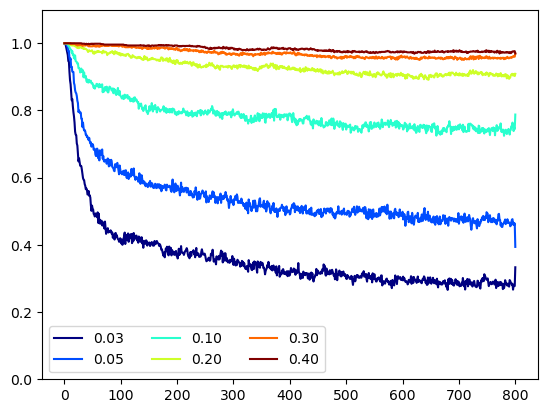

In [8]:
nc_thrs = np.linspace(0,1,21)
nc_thrs = [.025, .05, .1, .2, .3, .4]
nc_sens = df2sens(nc_df, nc_thrs, "NCF")

colors = pl.cm.jet(np.linspace(0,1,len(nc_thrs)))
for i,thr in enumerate(nc_thrs):
    pl.plot(nc_sens.loc[nc_sens.Threshold==thr,"Unbound"], 
            color=colors[i], label=f"{thr:.02f}")
    pl.ylim(0,1.1)
pl.legend(loc="lower left", ncol=3)

In [25]:
tmp=rmsd_df.groupby("Trajectory")

In [33]:
bbb["Frame"].max()

799

In [48]:
def df2surv(df, thr, column, less_is_bound=False):
    surv=[]
    df=df.copy(deep=True)
    df["Bound"]=df[column]<=thr if less_is_bound else df[column]>=thr 
    dft = df.groupby("Trajectory")
    for trn,trdf in dft:
        tmp = (False, trdf["Frame"].max())
        mintbound = trdf.loc[trdf["Bound"],"Frame"].min()
        if not np.isnan(mintbound):
            tmp = (True, mintbound)
        surv.append(tmp)
    surv = pd.DataFrame.from_records(surv)
    surv.columns=["Status","Time (ns)"]
    return surv
        
        


In [53]:
rmsd_surv_5 = df2surv(rmsd_df, 5, 0, less_is_bound=True)
rmsd_surv_5

,Status,Time (ns)
0,False,799
1,False,799
2,False,796
3,False,799
4,False,759
...,...,...
767,False,799
768,False,799
769,False,799
770,False,799


Text(0.5, 0, 'Time $t$ (ns)')

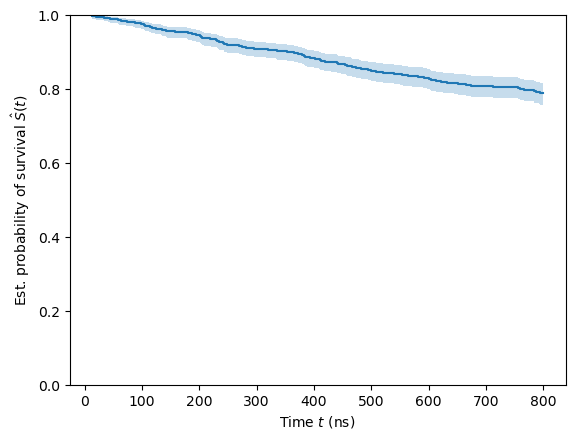

In [56]:
from sksurv.nonparametric import kaplan_meier_estimator

time, survival_prob, conf_int = kaplan_meier_estimator(
    rmsd_surv_5["Status"], rmsd_surv_5["Time (ns)"], conf_type="log-log"
)
plt.step(time, survival_prob, where="post")
plt.fill_between(time, conf_int[0], conf_int[1], alpha=0.25, step="post")
plt.ylim(0, 1)
plt.ylabel("Est. probability of survival $\hat{S}(t)$")
plt.xlabel("Time $t$ (ns)")

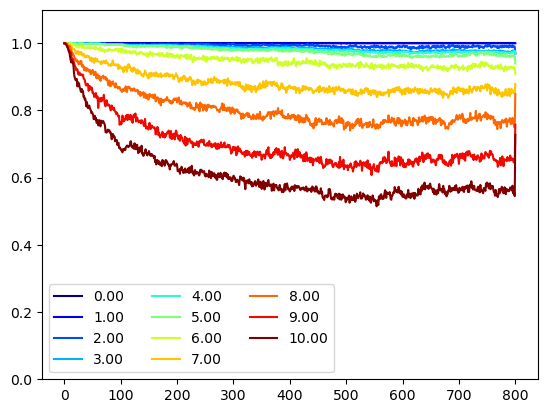

In [10]:
rmsd_thrs = np.linspace(0,10,11)
rmsd_sens = df2sens(rmsd_df, rmsd_thrs, 0, less_is_bound=True)

colors = pl.cm.jet(np.linspace(0,1,len(rmsd_thrs)))
for i,thr in enumerate(rmsd_thrs):
    pl.plot(rmsd_sens.loc[rmsd_sens.Threshold==thr,"Unbound"], 
            color=colors[i], label=f"{thr:.02f}")
    pl.ylim(0,1.1)
pl.legend(loc="lower left", ncol=3)
